## Лабораторная работа №1

Задание 1. Найти набор данных (датасет) для классификации удовлетворяющий следующим условиям: более 10 000 строк, более 20 столбцов, разные типы в столбцах, обязательно наличие целевого признака (таргета).

Задание 2 . Провести классификацию найденного датасета, методом к- ближайших соседей. В формате Markdown писать пояснения. Объяснить почему были выбраны именно такие гиперпараметры, была ли перекрестная проверка, и т.д.

In [20]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import RandomizedSearchCV

import matplotlib.pyplot as plt

In [14]:
data = pd.read_csv('classified_data.csv')
print(data)


             ID  Loan Amount  Funded Amount  Funded Amount Investor  Term  \
0      65087372        10000          32236             12329.36286    59   
1       1450153         3609          11940             12191.99692    59   
2       1969101        28276           9311             21603.22455    59   
3       6651430        11170           6954             17877.15585    59   
4      14354669        16890          13226             13539.92667    59   
...         ...          ...            ...                     ...   ...   
67458  16164945        13601           6848             13175.28583    59   
67459  35182714         8323          11046             15637.46301    59   
67460  16435904        15897          32921             12329.45775    59   
67461   5300325        16567           4975             21353.68465    59   
67462  65443173        15353          29875             14207.44860    59   

      Batch Enrolled  Interest Rate Grade Sub Grade Employment Duration  ..

In [16]:
label_encoder = LabelEncoder()

# data['Grade Encoded'] = label_encoder.fit_transform(data['Grade'])
# data['Sub Grade Encoded'] = label_encoder.fit_transform(data['Sub Grade'])
# data['Employment Duration Encoded'] = label_encoder.fit_transform(data['Employment Duration'])
# data['Verification Status Encoded'] = label_encoder.fit_transform(data['Verification Status'])
# data['Loan Title Encoded'] = label_encoder.fit_transform(data['Loan Title'])
# data['Initial List Status Encoded'] = label_encoder.fit_transform(data['Initial List Status'])

non_numeric_columns = data.select_dtypes(exclude=['number']).columns.tolist()

data = data.drop(columns=non_numeric_columns)
data = data.drop("ID", axis=1)
data = data.drop("Accounts Delinquent", axis=1)
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67463 entries, 0 to 67462
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Loan Amount                   67463 non-null  int64  
 1   Funded Amount                 67463 non-null  int64  
 2   Funded Amount Investor        67463 non-null  float64
 3   Term                          67463 non-null  int64  
 4   Interest Rate                 67463 non-null  float64
 5   Home Ownership                67463 non-null  float64
 6   Debit to Income               67463 non-null  float64
 7   Delinquency - two years       67463 non-null  int64  
 8   Inquires - six months         67463 non-null  int64  
 9   Open Account                  67463 non-null  int64  
 10  Public Record                 67463 non-null  int64  
 11  Revolving Balance             67463 non-null  int64  
 12  Revolving Utilities           67463 non-null  float64
 13  T

0    42836
1    42836
Name: Loan Status, dtype: int64
[0 1]


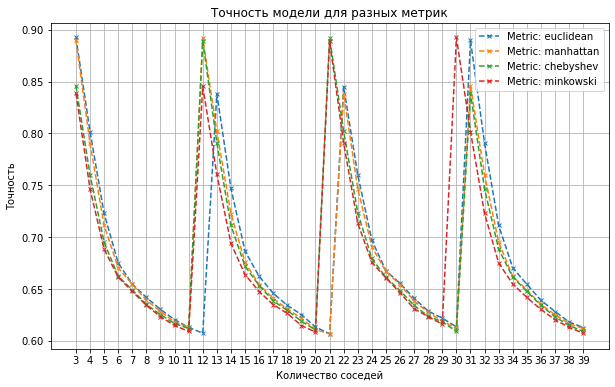

Лучшие параметры: Количество соседей = 3, Лучшая метрика = euclidean


In [26]:
from imblearn.over_sampling import RandomOverSampler

X = data.drop(columns=['Loan Status'])
y = data['Loan Status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#Балансировка данных
under_sampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = under_sampler.fit_resample(X_train, y_train)

print(pd.Series(y_resampled).value_counts())
print(y_test.unique())

knn = KNeighborsClassifier()

param_grid = {'n_neighbors': range(3, 40),
              'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']}

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_resampled, y_resampled)

best_params = grid_search.best_params_
best_metric = best_params['metric']
best_k = best_params['n_neighbors']

accuracies = grid_search.cv_results_['mean_test_score']
accuracies = np.array(accuracies).reshape(len(param_grid['n_neighbors']), len(param_grid['metric']))

plt.figure(figsize=(10, 6))

for i, metric in enumerate(param_grid['metric']):
    plt.plot(param_grid['n_neighbors'], accuracies[:, i], marker='x', linestyle='dashed', markersize=4,
             label=f'Metric: {metric}')

plt.title('Точность модели для разных метрик')
plt.xlabel('Количество соседей')
plt.ylabel('Точность')
plt.xticks(range(3, 40))
plt.legend()
plt.grid(True)
plt.show()

print(f"Лучшие параметры: Количество соседей = {best_k}, Лучшая метрика = {best_metric}")

In [27]:
knn = KNeighborsClassifier(n_neighbors=best_k, metric=best_metric)
knn.fit(X_resampled, y_resampled)

y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Точность модели с {best_k} соседями и метрикой {best_metric}: {accuracy}")

report = classification_report(y_test, y_pred, zero_division=1)
print(report)

Точность модели с 3 соседями и метрикой euclidean: 0.7668857156974159
              precision    recall  f1-score   support

           0       0.91      0.83      0.87     18386
           1       0.09      0.18      0.12      1853

    accuracy                           0.77     20239
   macro avg       0.50      0.50      0.49     20239
weighted avg       0.83      0.77      0.80     20239

